## E-commerce Revenue Prediction - Time Series

Data source: [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx).

#### Project description:
Predict revenue for the next 30 days.

#### Content
1. Importing required libraries
2. Data Loading & Preprocessing
	1. Handling outliers
	2. Inspecting the revenue ditribution
3. Revenue Forecast with SARIMA
	1. Model identification & model selection
		1. Train Test Split
		1. Stationary Status Check
			1. Seasonal-Trend decomposition
			1. ADF hypothesis test
			1. KPSS hypothesis test
			1. Plotting ACF/PACF
			1. Differencing
	2. Model Order Estimation
	3. Statistical model checking
	4. Cross Validation & Model Error Estimation
	5. Predicting Future Revenue

### 1. Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

import gc # to garbage collect
import warnings
warnings.filterwarnings("ignore")

In [2]:
# visualiztion settings
plt.style.use('ggplot')
sns.set(style='white')

### 2. Data Loading & Preprocessing
In this project, we use the data we cleaned in Data_Cleaning_mini_project.ipynb <br/>
For more details refer to Data_Cleaning_mini_project.ipynb cleaning section.

In [44]:
# importing dtype metadata
mapper = pd.read_csv('.\sales_cleaned_data_map.csv', index_col='column_name')
mapper.head()

# we change 'datetime64[ns]' to object and parse dates seperately, since pandas can't handle them in the mapper
dt_cols = mapper.loc[mapper.data_type == 'datetime64[ns]'].index.tolist()
mapper.replace({'datetime64[ns]': 'object'}, inplace=True)

# import the cleaned file data
sales = pd.read_csv('.\sales_cleaned.csv', dtype=mapper.to_dict()['data_type'], parse_dates=dt_cols)

sales.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_zip_code_prefix,customer_city,customer_state,customer_geo_lat,customer_geo_lng,seller_zip_code_prefix,seller_city,seller_state,seller_geo_lat,seller_geo_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,03149,sao paulo,SP,-23.576818,-46.587181,09350,maua,SP,-23.680704,-46.444324
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,03149,sao paulo,SP,-23.576818,-46.587181,09350,maua,SP,-23.680704,-46.444324
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,03149,sao paulo,SP,-23.576818,-46.587181,09350,maua,SP,-23.680704,-46.444324
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,87285b34884572647811a353c7ac498a,...,03366,sao paulo,SP,-23.564508,-46.534172,09350,maua,SP,-23.680704,-46.444324
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,87285b34884572647811a353c7ac498a,...,02290,sao paulo,SP,-23.537735,-46.628426,09350,maua,SP,-23.680704,-46.444324


In [4]:
# creating the revenue column and dfs 
df = sales.loc[:, ['order_purchase_timestamp', 'price']].rename(columns={'order_purchase_timestamp': 'date', 'price': 'revenue'})
df['date'] = df.date.dt.normalize()
df.set_index('date', inplace=True)
df = df.resample('D').sum()
df = df.iloc[:-13, :] # dropping the last empty & inconsistent rows
df.tail()

,revenue
date,
2018-08-17,32310.910156
2018-08-18,24260.880859
2018-08-19,26441.609375
2018-08-20,34020.070312
2018-08-21,26493.269531


In [5]:
# we don't need sales df anymore
del sales
gc.collect()

16

#### Data preparation & EDA

Inspecting the data

In [6]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
revenue,594.0,23289.41,12690.48,396.9,14324.36,21744.73,30713.41,155898.47


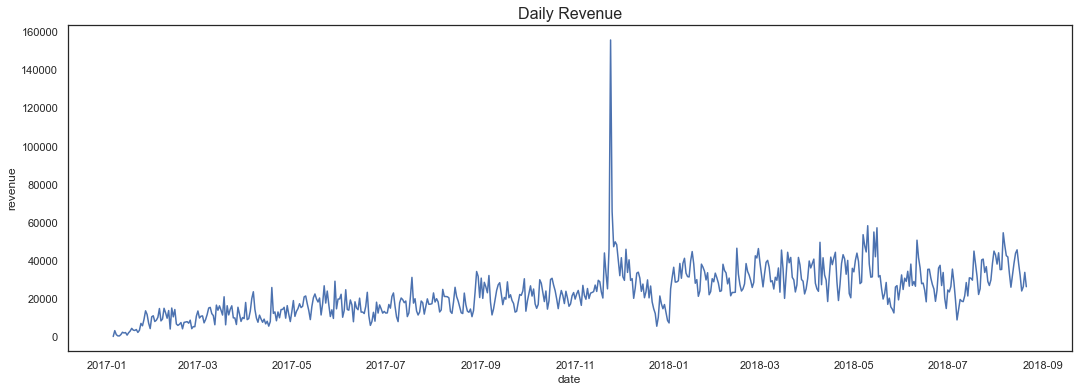

In [7]:
plt.figure(figsize=(18, 6))
sns.lineplot(x=df.index, y=df.revenue)
plt.title('Daily Revenue', fontsize=16)
plt.show()

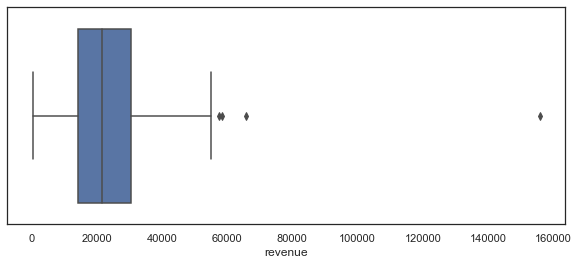

In [8]:
plt.figure(figsize=(10, 4))
sns.boxplot(df.revenue, orient='h')
plt.show()

We have a few outliers that need to be smoothen out.

#### Handling outliers

To identify outliers we use Tukey’s method and will replace their values with the average value of 3 days before and after.

In [9]:
# identifying outliers and replacing them with a moving average
def adjust_outliers(df, col_name, window_in_days=3):

    # calculating IQR & Tukey's Method boundries
    q1 = df.quantile(0.25).values
    q3 = df.quantile(0.75).values

    iqr = q3-q1
    lower_fence = q1 - 1.5*iqr
    upper_fence = q3 + 1.5*iqr

    # calculating moving average a the given window
    df_rolling = df.rolling(window_in_days, min_periods=1, center=True).mean()

    # identifying outliers
    outliers_dates=[]
    for date, revenue in zip(df.index, df[col_name]):
        if (revenue<=lower_fence) or (revenue>=upper_fence):
            outliers_dates.append(date)
    
    # replacing outliers with moving average
    for outlier_date in outliers_dates:
        df.loc[outlier_date] = df_rolling.loc[outlier_date]
        # capping at upper_fence if the value is still high
        if df.loc[outlier_date].values>upper_fence:
            df.loc[outlier_date] = upper_fence
        if df.loc[outlier_date].values<lower_fence:
            df.loc[outlier_date] = lower_fence

    return df

In [10]:
# smoothening outliers
df = adjust_outliers(df, 'revenue', window_in_days=3)

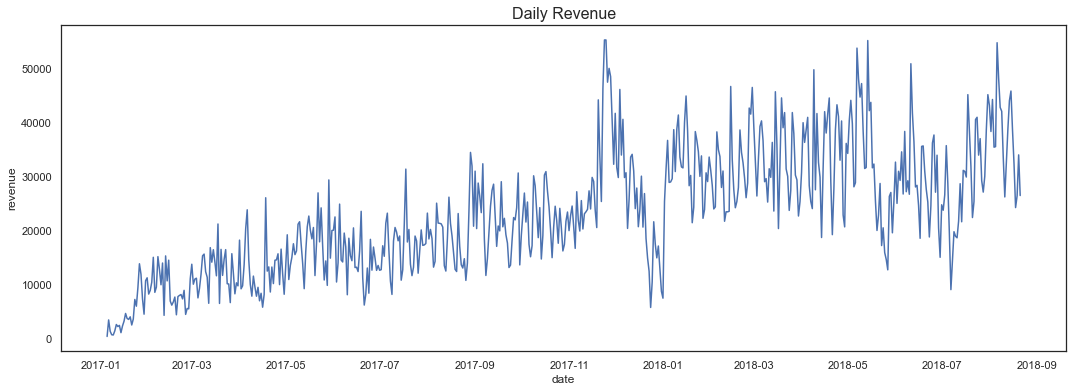

In [11]:
plt.figure(figsize=(18, 6))
sns.lineplot(x=df.index, y=df.revenue)
plt.title('Daily Revenue', fontsize=16)
plt.show()

#### Inspecting the revenue ditribution

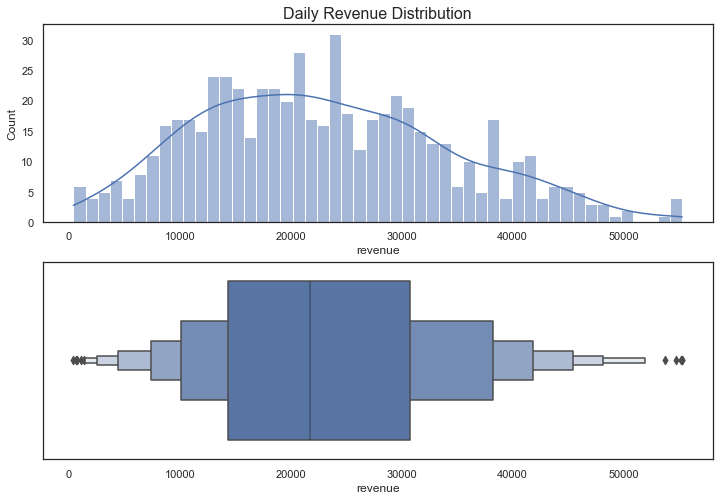

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
sns.histplot(df.revenue, bins=50, kde=True, ax=ax1)
sns.boxenplot(df.revenue, orient='h', ax=ax2)
ax1.set_title('Daily Revenue Distribution', fontsize=16)
plt.show()

The distribution is not completely symetrical and is right skewed.

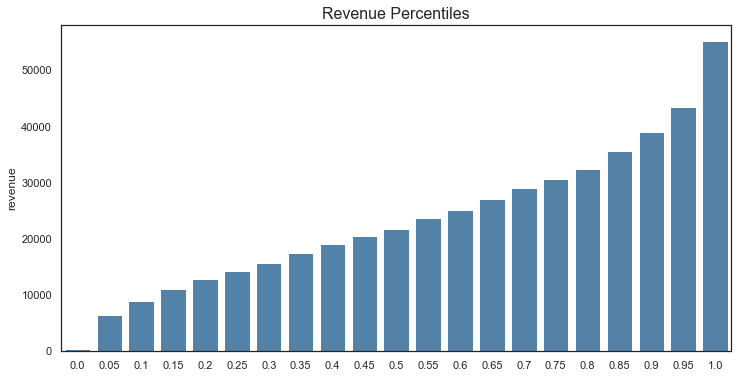

In [13]:
# Revenue by percentile
revenue_quantile = df.quantile(np.arange(0, 1.05, 0.05))

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=revenue_quantile.index, y=revenue_quantile.revenue, ax=ax, color='steelblue')
ax.set_xticklabels(np.arange(0, 1.05, 0.05).round(2))
ax.set_title('Revenue Percentiles', fontsize=16)
plt.show()

### 3. Revenue Forecast with SARIMA

We use Box–Jenkins method to find the best fit of time series model to the revenue data.<br/>
This modeling approach has 3 main stages:
1. Model identification and model selection
2. Model order selection (parameter estimation)
3. Statistical model checking

#### Model identification & model selection
https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc446.htm

In this stage, we assess if the time series is stationary. If not, we use differencing techniques to smoothen the non-stationary portion.

##### Train Test Split
We use a trian test split to avoid data leakage and overfitting in our analysis.

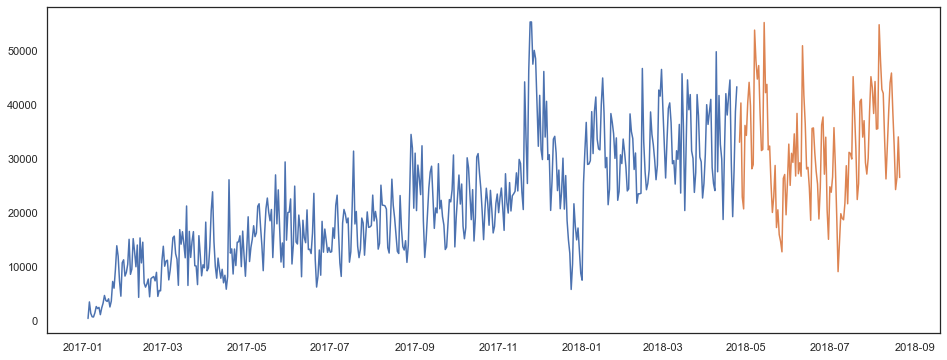

In [14]:
# train test split of the data
train_size = round(len(df)*0.8) # we select 80% for training set
X_train = df.iloc[:train_size]
X_test = df.iloc[train_size+1:]

plt.figure(figsize=(16, 6))
plt.plot(X_train)
plt.plot(X_test)
plt.show()

##### Stationary Status Check
In this stage, we plot the data to see if we have a flat looking series that has no obvious trend or periodic fluctuations (seasonality).
We like our data to have a constant variance and autocorrelation structure over time.<br/>

In [15]:
# calculating and plotting moving average and std
def plot_cyclicality(ts, window=7):
    moving_average = ts.rolling(window=window).mean()
    moving_std = ts.rolling(window=window).std()

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(ts.index, ts, label='Daily Revenue')
    ax.plot(ts.index, moving_average, color='crimson', linestyle='--', label='Rolling Mean')
    ax.plot(ts.index, moving_std, color='black', linestyle='--', label='Rolling STD')
    ax.set_title(f'{window}-day Rolling Mean and Standard Deviation', fontsize=16)
    ax.set_ylabel('Daily Revenue', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

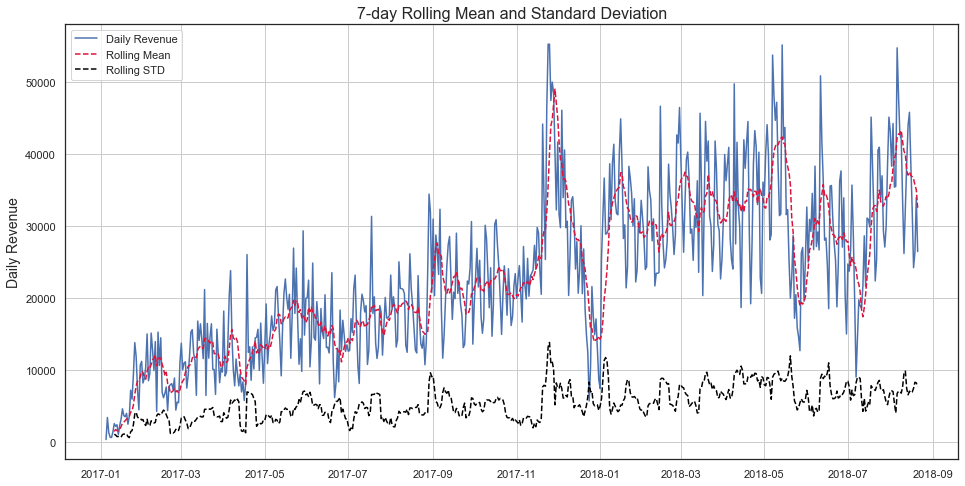

In [16]:
plot_cyclicality(df.revenue, window=7)

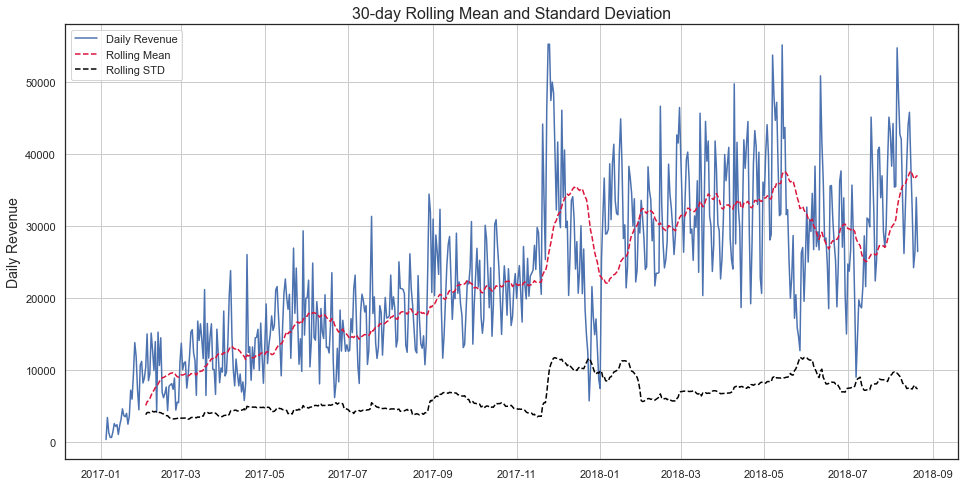

In [17]:
plot_cyclicality(df.revenue, window=30)

The mean and standard deviation are showing an uptrend indicating that the flactuations may not be only due to white noise but more likely there is some sort of trend/seasonality going on in our dataset.

<strong>Seasonal-Trend decomposition</strong> <br/>
We can decompose trend and seasonality using seasonal_decompose that uses the moving average for decomposition.
This plot seperates trend and seasonality components and gives us a better understanding of the data.

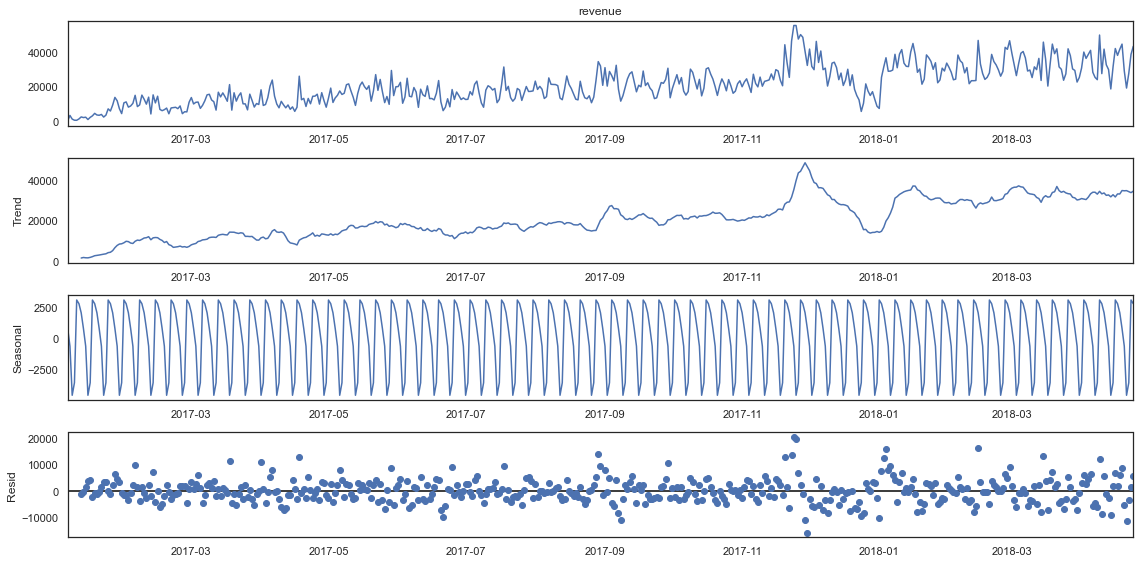

In [18]:
# Plotting for seasonality and trend for the training set
s_decomp = seasonal_decompose(X_train.revenue, two_sided=False)
plt.rcParams['figure.figsize'] = 16, 8
s_decomp.plot(observed=True, resid=True)
plt.show()

We can also plot the decompistion using Loess which is a method for estimating nonlinear relationships.

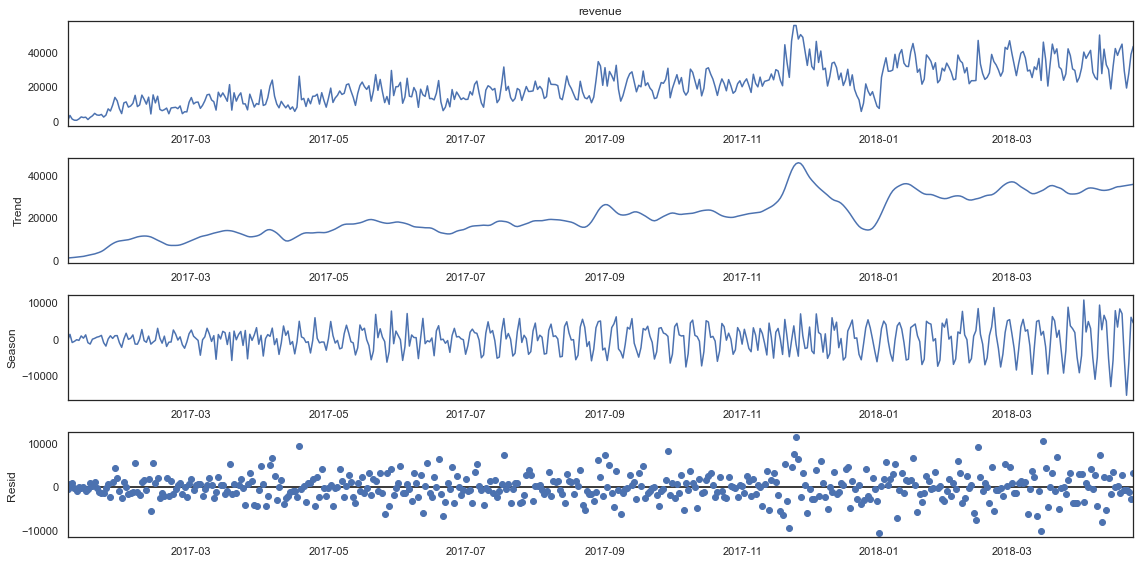

In [19]:
# Plotting for seasonality and trend for the training set
stl_decomp = STL(X_train.revenue, seasonal=7).fit()
plt.rcParams['figure.figsize'] = 16, 8
stl_decomp.plot(observed=True, resid=True)
plt.show()

Both MA based and non-linear decomposition methods showing trend and seasonality, indicating the data is non-stationary.

<strong>ADF hypothesis test</strong> <br/>
To ensure the status of the data, we run the Augmented Dickey-Fuller hypothesis test to see if the data is non-stationary.

In [20]:
# Runs an adf hypothesis test on data
def run_adfuller_test(ts, significance_level=0.05):
    
    # running the Augmented Dickey-Fuller hypothesis test
    adf_test = adfuller(ts)
    test_statistic = adf_test[0]
    p_value = adf_test[1]
    significance_level_percent = f'{int(significance_level*100)}%'
    
    # creating a ts for the results
    adf_test_results = pd.Series(adf_test[:4], index=['adf_test_statistic', 'p_value', 'num_used_lag', 'num_observations'])


    # looping through critical values dictionary
    for level, critical_value in adf_test[4].items():
        adf_test_results[f'critical_value_at_{level}'] = critical_value

        # Hypothesis testing
        # H0: Non Stationarity exists in the ts.
        # H1: Stationarity exists in the ts        
        if level == significance_level_percent:
            if (p_value <= significance_level) & (test_statistic <= critical_value):
                print('Reject the null hypothesis: the ts is stationarity.')
            else:
                print('Fail to reject the null hypothesis: the ts is non-stationarity.')

    return adf_test_results

In [21]:
# testing the training set
run_adfuller_test(X_train.revenue)

Fail to reject the null hypothesis: the ts is non-stationarity.


adf_test_statistic        -2.155202
p_value                    0.222904
num_used_lag              16.000000
num_observations         458.000000
critical_value_at_1%      -3.444709
critical_value_at_5%      -2.867871
critical_value_at_10%     -2.570142
dtype: float64

The result shows a p-value of 0.22 with the test statistic of -2.15<br/>
This means the test statistic falls out of 10% range (a confidence interval of less than 90%) which doesn't satisfy our significance level of 5% so we can not reject the null hypothesis and therefore, the data is non-stationary for the whole dataset.

<strong>KPSS hypothesis test</strong> <br/>

In [22]:
# performing kpss test
def run_kpsstest(ts, alpha=0.05):
    kpss_test = pm.arima.KPSSTest(alpha=alpha)
    p_value, sig = kpss_test.should_diff(ts)
    
    # Hypothesis testing
    # H0: Non-stationarity exists in the series
    # H1: Stationarity exists in the series        
    if sig==False:
        print(f'Reject the null hypothesis: the series is stationarity.\np-value={p_value}')
    else:
        print(f'Fail to reject the null hypothesis: the series is non-stationarity.\np-value={p_value}')

In [23]:
run_kpsstest(X_train.revenue, alpha=0.05)

Fail to reject the null hypothesis: the series is non-stationarity.
p-value=0.01


KPSS test returns the same result as ADF test.

<strong>Plotting ACF/PACF</strong> <br/>
Autocorrelation Function (ACF) is the correlation between the time series and its lagged veriosns (AR), and Partial Autocorrelation Function (PACF) is the direct correlation with a specific lagged time spot dismissing the time lags in between showing (MA).<br/>
We plot ACF and PACF to see if we can decide about the seasonality. 

In [24]:
# Plotting ACF and PCF

def plot_acf_pcf(ts, lags=100):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7))
    plt.rcParams['figure.figsize'] = 16, 4
    _ = plot_acf(ts, lags=lags, ax=ax1)
    _ = plot_pacf(ts, lags=lags, ax=ax2)
    ax1.set_title('Autocorrelation Function (ACF)', fontsize=16)
    ax2.set_title('Partial Autocorrelation Function (PACF)', fontsize=16)
    plt.tight_layout()
    plt.show()

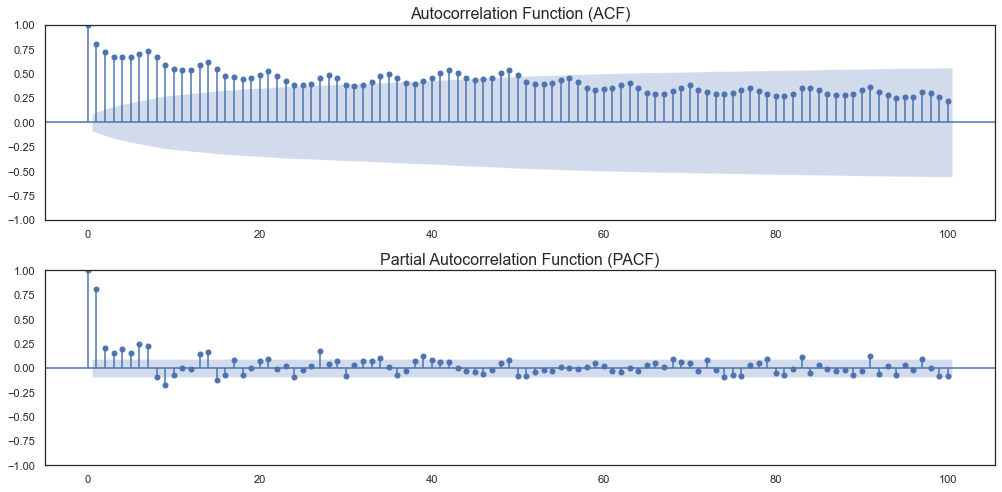

In [25]:
# plotting ACF/PCF plot for the training set
plot_acf_pcf(X_train, lags=100)

ARIMA model parameters:
- p: The number of time lags of the auto-regressive (AR) model (lag order/autoregressive order)
- d: The number of times that the raw observations are differenced (the degree of differencing)
- q: The order of the moving-average (MA) model which is the size of the moving average window (the order of the moving average)

SARIMA model additional parameters:
- P: The order of the auto-regressive portion of the seasonal model (Seasonal autoregressive order)
- D: The order of the seasonal differencing (Seasonal difference order)
- Q: The order of the moving-average portion of the seasonal model (Seasonal moving average order)
- m: The number of periods in each season

Looking at the plots, there is a significant positive spike in ACF and PCF
- ACF shows significant periodic AR terms peaking at lag 7, lag 14 and so on gradually decaying indicating a weekly seasonality. However, it seems addressing lag 1 may also be able to explain all the higher-order autocorrelations with the seasonal term of 7 as well.
- PACF shows a significat MA term at lag 1 and decaying fast

<strong>Differencing</strong><br/>
We use differencing to see if it allows us to decide about seasonality.

In [26]:
# plotting ACF with seasonal periods
def plot_acf_peaks(ts, m=7, nlags=100):
    X_train_diff = X_train.diff().dropna() # dropping the first row
    acf_lag = acf(X_train_diff, nlags=nlags)

    fig, ax = plt.subplots(figsize=(16, 5))

    plt.plot(acf_lag)
    for x in range(1, int(nlags/m)):
        plt.vlines(x=x*m, ymin=acf_lag.min(), ymax=acf_lag.max(), linestyle='--', color='red')
        plt.margins(y=0)
    plt.title(f'Autocorrelation Function with {m}-day Peak Interval', fontsize=16)
    plt.show()

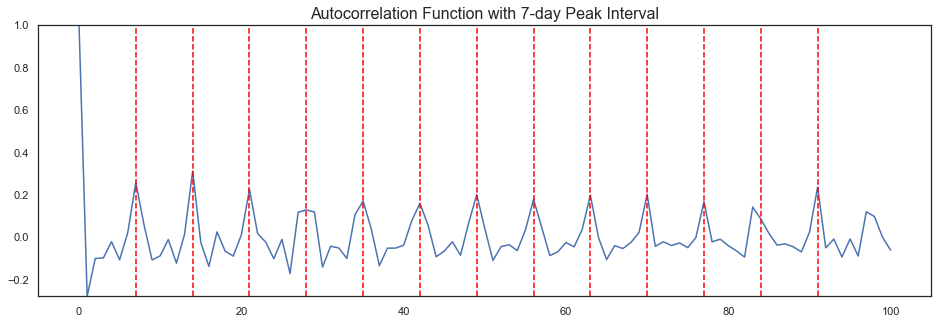

In [27]:
plot_acf_peaks(X_train, m=7, nlags=100)

Looking at the above chart, it seems by applying a seasonal differencing of m=7, we might be able to address the seasonality. We can check it again by ploting ACF/PCF plot of the first order differencing.

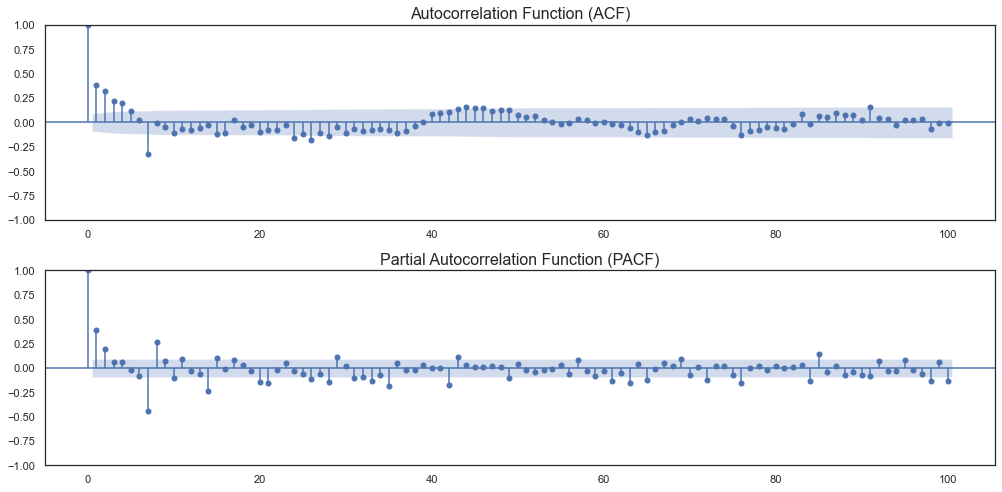

In [28]:
# differencing to offset the seasonality
train_seasonal_diff_first = X_train.diff(7).dropna()
# Plotting ACF/PCF after differencing
plot_acf_pcf(train_seasonal_diff_first, lags=100)

#### Model Order Estimation

The seasonal differencing was able to significantly smoothen the plots. <br/>
Now that we know m=7, we can estimate d and D using pmdarima.

In [29]:
# Estimate ARIMA differencing terms d and D
def estimate_d(ts, m=7):

    # -----Finding d-----
    
    # Type of unit root test of stationarity to use in order to test the stationarity of the time-series.
    d_tests = {'kpss':0, 'adf':0, 'pp':0}

    for d_test in d_tests.keys():
        d_param = pm.arima.ndiffs(ts, alpha=0.05, max_d=2, test=d_test)
        d_tests.update({d_test:d_param})

    # -----Finding D (seasonal)-----
    
    if m>0:
        # Type of unit root test of seasonality to use in order to detect seasonal periodicity. 
        D_seasonal_tests = {'ocsb':0, 'ch':0}

        for D_seasonal_test in D_seasonal_tests.keys():
            D_seasonal_param = pm.arima.nsdiffs(ts, m, max_D=2, test=D_seasonal_test)
            D_seasonal_tests.update({D_seasonal_test:D_seasonal_param})
    
    else:
        D_seasonal_tests = (0, 0, 0, 0)
    
    return f'd: {d_tests}, D: {D_seasonal_tests}'

In [30]:
# estimating d and D
estimate_d(X_train.revenue, m=7)

"d: {'kpss': 1, 'adf': 0, 'pp': 0}, D: {'ocsb': 0, 'ch': 0}"

d is estimated to be 0 by adf and pp methods but 1 by kpps method.<br/>
D is estimated to be 0 by both ocsb and ch methods.

<strong>Estimating best parameters</strong> <br/>
We use pmdarima to do a grid search and calculate the best parameters for us.<br/>
We use m=7, d=0 and D=0 and let the solver find the best values for p, q, P, and Q parameters.

In [31]:
# finding the best model orders
auto_arima_best_model = pm.auto_arima(X_train, seasonal=True, m=7, d=0, D=0, start_p=1, start_q=1, max_d=1,
                                with_intercept='auto', scoring='mse', max_order=7, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=9577.578, Time=1.75 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=10171.295, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=9609.408, Time=0.35 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=9794.833, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=10912.244, Time=0.02 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=9597.490, Time=0.16 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=9581.303, Time=0.55 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.59 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=9639.340, Time=0.08 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=9564.002, Time=0.34 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=9876.085, Time=0.23 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=9603.026, Time=0.34 sec
 ARIMA(2,0,1)(0,0,2)[7] intercept   : AIC=9564.616, Time=0.69 sec
 ARIMA(1,0,2)(0,0,2)[7] intercept   : AIC

In [32]:
auto_arima_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  475
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 7)   Log Likelihood               -4733.397
Date:                             Thu, 10 Mar 2022   AIC                           9484.795
Time:                                     17:01:10   BIC                           9522.264
Sample:                                          0   HQIC                          9499.530
                                             - 475                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2035      0.132      1.540      0.124      -0.056       0.463
ar.L2         -0.1034      0.127     -0.817      0.414      -0.352       0.145
ar.L3          0.7727      0.112      6.896      0.000       0.553       0.992
ma.L1          0.1963      0.139      1.408      0.159      -0.077       0.470
ma.L2          0.3991      0.109      3.659      0.000       0.185       0.613
ma.L3         -0.5380      0.067     -8.090      0.000      -0.668      -0.408
ar.S.L7        0.9945      0.008    125.489      0.000       0.979       1.010
ma.S.L7       -0.9042      0.041    -22.073      0.000      -0.984      -0.824
sigma2      3.133e+07    1.9e-09   1.65e+16      0.000    3.13e+07    3.13e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                94.64
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               2.57   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+32. Standard errors may be unstable.
"""

Note: The singular or near-singular covariance matrix may be an indication of overfitting. We will examine it shortly on the test set and will see how the model performs.

#### Statistical model checking

In [33]:
order = auto_arima_best_model.get_params()['order']
seasonal_order = auto_arima_best_model.get_params()['seasonal_order']

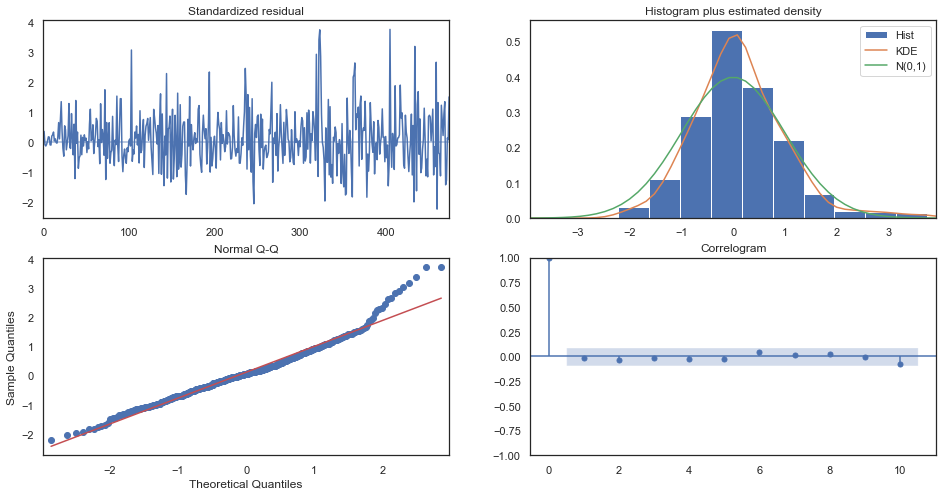

In [34]:
# checking models statistics
auto_arima_best_model.plot_diagnostics(figsize=(16,8))
plt.show()

The model deviation at the right tail of the normal probability plot indicates we have a heavy tailed residuals which we can see in the histogram as well. So for the model, the requirement for the residuals (error terms) to be be normally distributed is not fully met. <br/>
We may need to tune our model and perhaps test other orders to get a better fitting model or we may need to test other models other than SARIMA altogether.<br/>

#### Cross Validation & Model Error Estimation

We use walk forward validation to cross validate our model.

In [41]:
# walk forward validation cross validation
def build_walk_forward_validation(train, test, order, seasonal_order, plot=True):
    
    predictions = []
    # creating the initial array for walk forward cv
    data = train.values

    for i in test.values:
        # fitting the model to the training data (using non derivative method nm for faster execution)
        model_fit = SARIMAX(data, order=order, seasonal_order=seasonal_order, trend='ct', method='nm', 
                            simple_differencing=False, enforce_stationarity=False).fit(disp=False)
        # predicting test walking forward
        yhat = model_fit.forecast(steps=len(test.values))[0]

        # adding yhat to the list of predictions
        predictions.append(yhat)
        
        # adding the test to the list of training data
        data = np.append(data, i)

    # creating the result dataframe including the actual test and predicted test values
    df_result = pd.DataFrame(test)
    df_result['prediction'] = predictions
    df_result.rename(columns={test.name: 'actual'}, inplace=True)

    # calculating rmse (the standard deviation of the residuals)
    rmse_error = rmse(df_result['actual'], df_result['prediction'])

    print(f'Model Orders:\n non-seasonal order:{order}, seasonal order: {seasonal_order}')
    print(f'Model walk forward cross validated RMSE: {rmse_error}')

    if plot:
        # plotting the output
        fig, ax = plt.subplots(figsize=(16, 6))
        sns.lineplot(df_result.index, df_result['actual'], lw=2, label='actual')
        sns.lineplot(df_result.index, df_result['prediction'], color='red', alpha=0.7, linestyle='--', lw=2.5, label='prediction')
        ax.set_title(f'Actual vs. Prediction\nModel: SARIMA{order}{seasonal_order}', fontsize=16)
        plt.legend(loc='best')
        plt.grid()
        plt.show()

    return df_result, rmse_error

Model Orders:
 non-seasonal order:(3, 0, 3), seasonal order: (1, 0, 1, 7)
Model walk forward cross validated RMSE: 6959.464244882439


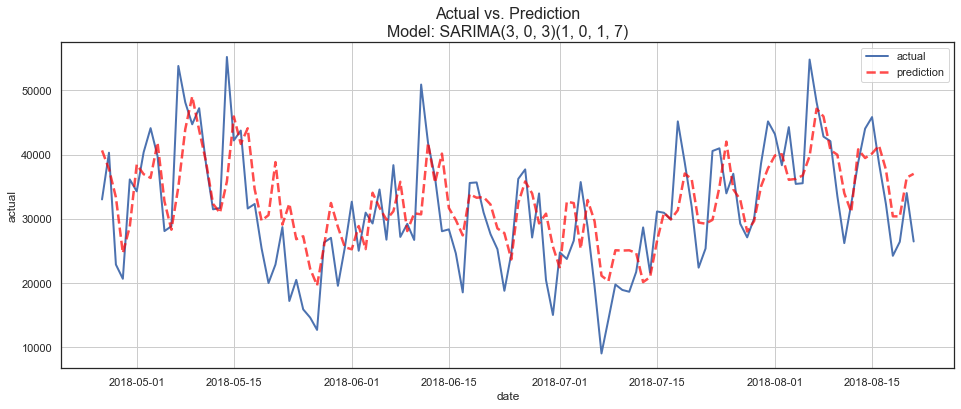

In [42]:
test_predictsions, pred_rmse = build_walk_forward_validation(X_train.revenue, X_test.revenue, order=order, seasonal_order=seasonal_order)

Our model prediction error is about $7000 which may not be that large considering the relatively small dataset we have and the fact that the daily revenue flactuates between $300 and $55000.<br/>
However, we can try hypertuning the paramaters to see if we get a better result. <br/>

#### Predicting Future Revenue
Assuming we are comfortable with the model performance, we can go ahead and predict the data for the next 30 days..

In [38]:
# predicting future sales
def plot_predicts(ts, order, seasonal_order, n_predictions=30, plot=True):

   # fitting the model to the training data (using non derivative method nm for faster execution)
   sarimax_model_fit = SARIMAX(df.revenue, order=order, seasonal_order=seasonal_order, trend='ct', 
                     simple_differencing=False, enforce_stationarity=False).fit(disp=False)
   predictions = sarimax_model_fit.forecast(steps=n_predictions)
   # getting lower bound and upper bound of confidence intervals of the model
   predictions_ci = sarimax_model_fit.get_forecast(steps=n_predictions).conf_int()

   # calculating the predicstions index
   prediction_index = pd.date_range(start=df.index[-1], periods=n_predictions+1, freq='D', normalize=True, closed='right')

   # creating the result dataframe including the actual test and predicted test values
   df_prediction = pd.DataFrame(predictions, index=prediction_index)

   if plot:
      # plotting
      fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))

      sns.lineplot(prediction_index, predictions, color='red', alpha=0.7, lw=2.5, label='prediction', ax=ax1)
      ax1.set_title(f'Prediction for next {n_predictions} days\nModel: SARIMA{order}{seasonal_order}', fontsize=16)

      sns.lineplot(df.index, df['revenue'], lw=2, label='actual', ax=ax2)
      sns.lineplot(prediction_index, predictions, color='red', alpha=0.7, lw=2.5, label='prediction', ax=ax2)
      ax2.fill_between(prediction_index, predictions_ci.iloc[:, 0], predictions_ci.iloc[:, 1], color='black', alpha=0.3)
      ax2.set_title(f'Actual & Predictions', fontsize=16)

      ax2.legend(loc='upper left')
      plt.grid()
      plt.show()

   return df_prediction

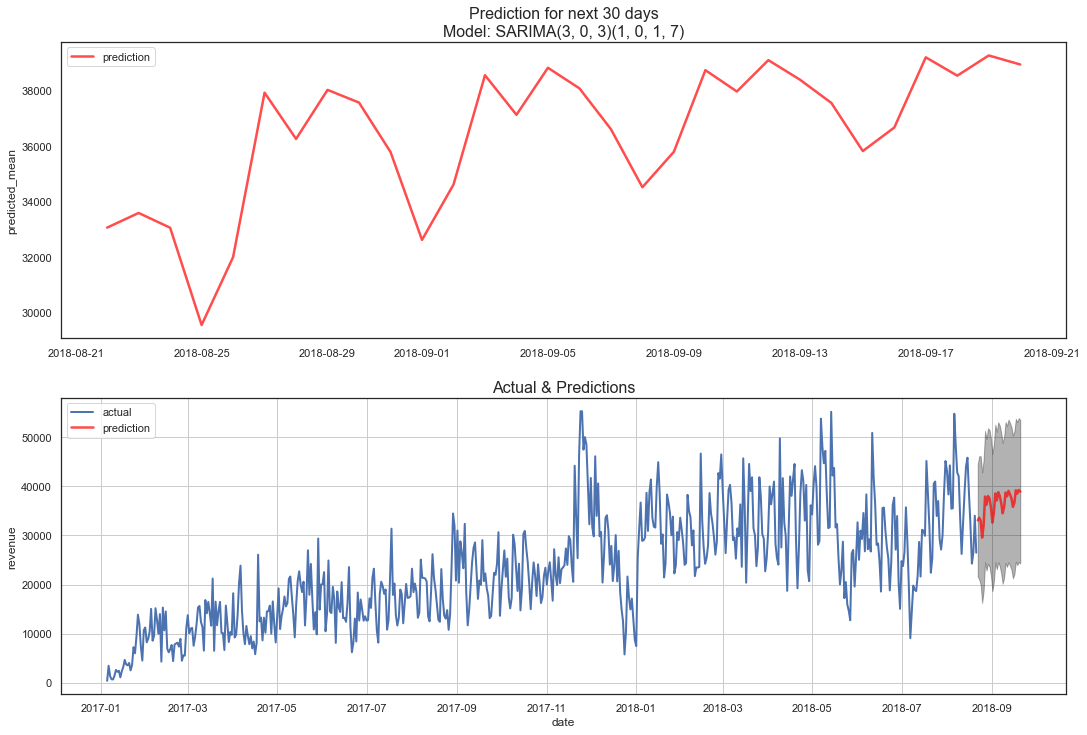

In [39]:
# getting 30 days predictions
df_prediction = plot_predicts(df.revenue, order=order, seasonal_order=seasonal_order, n_predictions=30)

In [43]:
df_prediction.head()

,predicted_mean
2018-08-22,33066.096153
2018-08-23,33593.286181
2018-08-24,33062.259638
2018-08-25,29558.693558
2018-08-26,32004.059337
